In [96]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import Helper.Preprocessing as pp 
import Helper.Model as ml 

# Explore data


Nb Nan: 0
Columns name: ['Date' 'Open' 'High' 'Low' 'Close' 'Adj Close' 'Volume']


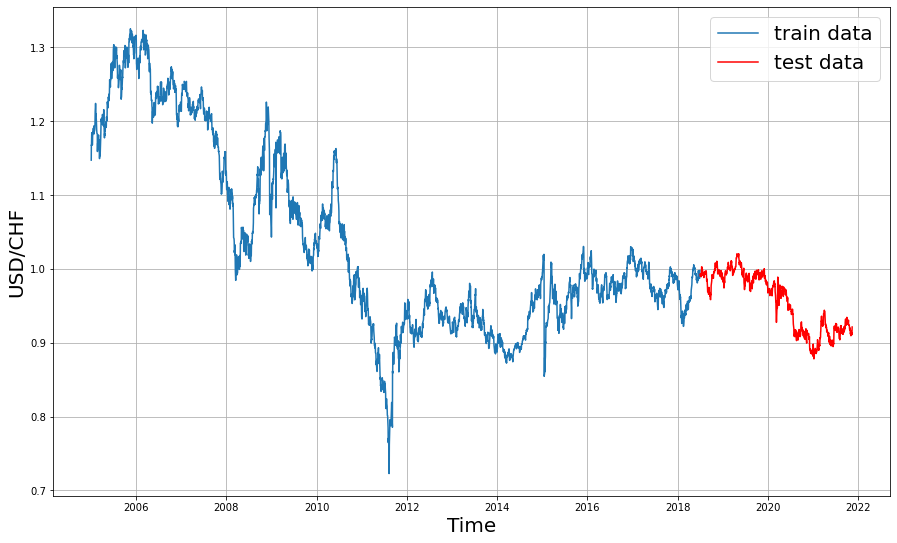

In [258]:
df = pd.read_csv("Data/CHF=X.csv")
#data cleaning & processing 
df.Date = pd.to_datetime(df.Date)
df = df.fillna(method="pad", limit=1)

for i in df.columns[1:]:
  df[i] = pd.to_numeric(df[i])
print(f'Nb Nan: {df.Close.isnull().sum()}')
print(f'Columns name: {df.columns.values}')

FRACTION_TEST = 0.2
nb_test = int(FRACTION_TEST*len(df))
plt.figure(figsize=(15, 9))
plt.plot(df.Date.values[:-nb_test],df.Close.values[:-nb_test], label="train data")
plt.plot(df.Date.values[-nb_test:], df.Close.values[-nb_test:], color="r", label="test data")
plt.xlabel("Time", fontsize=20)
plt.ylabel("USD/CHF", fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.show()

In [263]:
train_x, val_x, test_x, train_y, val_y, test_y, (mm, ss) = pp.generate_dataset(df.Close, lookback_=5, norm_=False, fraction_val_=0.2, fraction_test_=FRACTION_TEST)

Shape:         
X train     (2812, 5, 1), y train     (2812, 2)        
X train val (703, 5, 1) , y train val (703, 2)         
X test      (880, 5, 1) , y test      (880, 2)


# Generate model

In [264]:
model = ml.GRU_base(
        hidden_size=32,
        num_layers=1,
        input_size=1,
        out_features_lin=128,
        out_features_end=2)
model

GRU_base(
  (gru): GRU(1, 32, batch_first=True, dropout=0.25)
  (fc_0): Linear(in_features=32, out_features=128, bias=True)
  (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)

In [265]:
batch_size = 1024
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [266]:
device = 'cpu'
num_epochs = 25000
criterion_reg = nn.MSELoss()   
criterion_bin = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train_loss1= []
train_loss2= []

for epoch in tqdm.tqdm(range(1, num_epochs+1)):
    avg_loss1 = 0.
    avg_loss2 = 0.
    model.train()

    for x, label in train_loader:
        outputs = model(x.to(device).float())
        optimizer.zero_grad()

        if epoch%500 == 0:
            loss = criterion_reg(outputs[:,0].unsqueeze(1), label.to(device).float()[:,0].unsqueeze(1))
            avg_loss1 += loss.item()
            loss.backward()
        else:
            loss = criterion_bin(nn.Sigmoid()(outputs[:,1].unsqueeze(1)), label.to(device).float()[:,1].unsqueeze(1))
            avg_loss2 += loss.item()
            loss.backward()


        optimizer.step()
        
    if epoch%500 == 0:
        train_loss1.append(avg_loss1/(len(train_loader)))
    else:
        train_loss2.append(avg_loss2/(len(train_loader)))

    if epoch % 1000 == 0:
        print("Epoch: %d,\nloss MSE: %f" % (epoch, train_loss1[-1])) 
        print("loss BCE : %f" % (train_loss2[-1]))

  4%|▍         | 1005/25000 [00:39<14:18, 27.93it/s]

Epoch: 1000,
loss MSE: 2.133229
loss BCE : 0.671327


  8%|▊         | 2004/25000 [01:17<13:41, 27.98it/s]

Epoch: 2000,
loss MSE: 0.160321
loss BCE : 0.659657


 12%|█▏        | 3003/25000 [01:56<13:09, 27.85it/s]

Epoch: 3000,
loss MSE: 0.135168
loss BCE : 0.633976


 16%|█▌        | 4005/25000 [02:34<12:34, 27.83it/s]

Epoch: 4000,
loss MSE: 0.803380
loss BCE : 0.623777


 20%|██        | 5004/25000 [03:13<11:55, 27.95it/s]

Epoch: 5000,
loss MSE: 0.123918
loss BCE : 0.558731


 24%|██▍       | 6003/25000 [03:51<11:18, 28.00it/s]

Epoch: 6000,
loss MSE: 0.285761
loss BCE : 0.525616


 28%|██▊       | 7005/25000 [04:29<10:45, 27.90it/s]

Epoch: 7000,
loss MSE: 0.254323
loss BCE : 0.528462


 32%|███▏      | 8003/25000 [05:09<10:11, 27.77it/s]

Epoch: 8000,
loss MSE: 0.386148
loss BCE : 0.478466


 36%|███▌      | 9005/25000 [05:47<09:32, 27.94it/s]

Epoch: 9000,
loss MSE: 0.426450
loss BCE : 0.476226


 40%|████      | 10004/25000 [06:26<09:31, 26.24it/s]

Epoch: 10000,
loss MSE: 0.475685
loss BCE : 0.442381


 44%|████▍     | 11003/25000 [07:05<08:28, 27.54it/s]

Epoch: 11000,
loss MSE: 0.455238
loss BCE : 0.436025


 48%|████▊     | 12005/25000 [07:43<07:43, 28.04it/s]

Epoch: 12000,
loss MSE: 0.591862
loss BCE : 0.415243


 52%|█████▏    | 13004/25000 [08:22<07:17, 27.44it/s]

Epoch: 13000,
loss MSE: 0.739201
loss BCE : 0.404405


 56%|█████▌    | 14003/25000 [09:00<06:37, 27.63it/s]

Epoch: 14000,
loss MSE: 0.540128
loss BCE : 0.416380


 60%|██████    | 15005/25000 [09:39<06:02, 27.58it/s]

Epoch: 15000,
loss MSE: 0.770551
loss BCE : 0.394947


 64%|██████▍   | 16004/25000 [10:18<05:25, 27.68it/s]

Epoch: 16000,
loss MSE: 0.974074
loss BCE : 0.363545


 68%|██████▊   | 17003/25000 [10:56<04:49, 27.62it/s]

Epoch: 17000,
loss MSE: 0.725083
loss BCE : 0.463904


 72%|███████▏  | 18005/25000 [11:35<04:14, 27.53it/s]

Epoch: 18000,
loss MSE: 0.870478
loss BCE : 0.375419


 76%|███████▌  | 19004/25000 [12:13<03:35, 27.85it/s]

Epoch: 19000,
loss MSE: 1.048860
loss BCE : 0.351814


 80%|████████  | 20003/25000 [12:52<03:01, 27.58it/s]

Epoch: 20000,
loss MSE: 0.884939
loss BCE : 0.387919


 84%|████████▍ | 21005/25000 [13:30<02:23, 27.84it/s]

Epoch: 21000,
loss MSE: 1.025178
loss BCE : 0.359427


 88%|████████▊ | 22004/25000 [14:09<01:49, 27.38it/s]

Epoch: 22000,
loss MSE: 1.454866
loss BCE : 0.324547


 92%|█████████▏| 23003/25000 [14:47<01:12, 27.56it/s]

Epoch: 23000,
loss MSE: 0.925404
loss BCE : 0.347921


 96%|█████████▌| 24005/25000 [15:26<00:36, 27.56it/s]

Epoch: 24000,
loss MSE: 1.323020
loss BCE : 0.323358


100%|██████████| 25000/25000 [16:04<00:00, 25.91it/s]

Epoch: 25000,
loss MSE: 1.145436
loss BCE : 0.322708


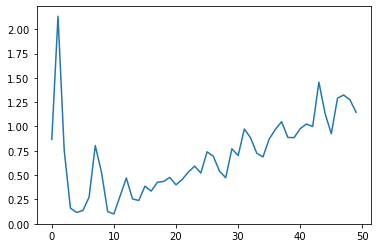

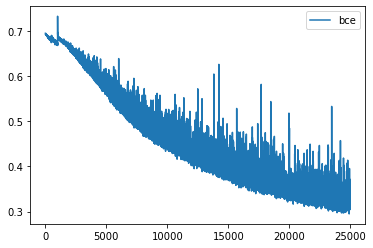

In [267]:
plt.plot(train_loss1, label="mse")
plt.show()
plt.plot(train_loss2, label="bce")
plt.legend()

In [268]:
def evaluate(model, x_, y_):
    model.eval()

    outputs = []
    targets = []
    
    inp = torch.from_numpy(np.array(x_))
    labs = torch.from_numpy(np.array(y_))

    out = model(inp.to(device).float())
    outputs1 = out.cpu().detach().numpy()
    targets1 = labs.numpy().reshape(-1)

    outputs1 = out.cpu().detach().numpy()[:, 0]
    targets1 = labs.numpy()[:, 0]

    outputs2 = nn.Sigmoid()(out[:, 1]).cpu().detach().numpy().round()
    targets2 = labs.numpy()[:, 1]

    MSE = np.mean((outputs1-targets1)**2)
    Acc = np.mean(outputs2 == targets2)
    print("MSE: {}%".format(MSE*100))
    print("Accuracy: {}%".format(Acc*100))
    return outputs1, targets1,outputs2, targets2, MSE, Acc

In [269]:
outputs1, targets1,outputs2, targets2, MSE, Acc = evaluate(model, test_x, test_y)


MSE: 38.70466089587455%
Accuracy: 50.34090909090909%


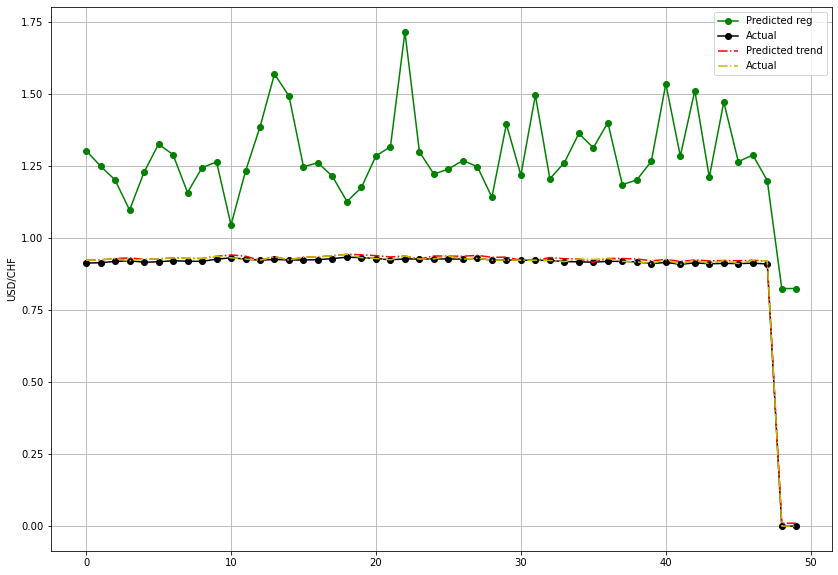

In [270]:
plt.figure(figsize=(14,10))

nb = 50
plt.plot(outputs1[-nb:], "-o", color="g", label="Predicted reg")
plt.plot(targets1[-nb:],"-o", color="k", label="Actual")

plt.plot(outputs2[-nb:]/100 + targets1[-nb:], "-.", color="r", label="Predicted trend")
plt.plot(targets2[-nb:]/100 + targets1[-nb:],"-.", color="y", label="Actual")
plt.ylabel('USD/CHF')
plt.grid()
plt.legend()
